# Introduction to Predictive Maintenance

#### Author Nagdev Amruthnath
Date: 1/9/2019

##### Citation Info
If you are using this for your research, please use the following for citation. 

Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

##### Disclaimer
This is a tutorial for performing fault detection using machine learning. You this code at your own risk. I do not gurantee that this would work as shown below. If you have any suggestions please branch this project.

## Introduction
This is the first of four part demostration series of using machine learning for predictive maintenance.   

The area of predictive maintenance has taken a lot of prominence in the last couple of years due to various reasons. With new algorithms and methodologies growing across different learning methods, it has remained a challenge for industries to adopt which method is fit, robust and provide most accurate detection. Fault detection is one of the critical components of predictive maintenance; it is very much needed for industries to detect faults early and accurately. In a production environment, to minimize the cost of maintenance, sometimes it is required to build a model with minimal or no historical data. In such cases, unsupervised learning would be a better option model building. In this paper, we have chosen a simple vibration data collected from an exhaust fan, and have fit different unsupervised learning algorithms such as PCA T2 statistic, Hierarchical clustering, K-Means, Fuzzy C-Means clustering and model-based clustering to test its accuracy, performance, and robustness. In the end, we have proposed a methodology to benchmark different algorithms and choosing the final model


## Load libraries 

In [2]:
options(warn=-1)

# load libraries
library(mdatools) #mdatools version 0.9.1
library(caret)
library(foreach)
library(dplyr)
library(mclust)

## Load data
Here we are using data from a bench press. There are total of four different states in this machine and they are split into four different csv files. We need to load the data first. In the data time represents the time between samples, ax is the acceleration on x axis, ay is the acceleration on y axis, az is the acceleration on z axis and at is the G's. The data was collected at sample rate of 100hz.   

Four different states of the machine were collected  
1. Nothing attached to drill press
2. Wooden base attached to drill press
3. Imbalance created by adding weight to one end of wooden base
4. Imbalacne created by adding weight to two ends of wooden base.

In [3]:
#setwd("/Experiment")
#read csv files
file1 = read.csv("dry run.csv", sep=",", header =T)
file2 = read.csv("base.csv", sep=",", header =T)
file3 = read.csv("imbalance 1.csv", sep=",", header =T)
file4 = read.csv("imbalance 2.csv", sep=",", header =T)
head(file1)

time,ax,ay,az,aT
0.002,-0.3246,0.2748,0.1502,0.451
0.009,0.6020,-0.1900,-0.3227,0.709
0.019,0.9787,0.3258,0.0124,1.032
0.027,0.6141,-0.4179,0.0471,0.744
0.038,-0.3218,-0.6389,-0.4259,0.833
0.047,-0.3607,0.1332,-0.1291,0.406


We can look at the summary of each file using summary function in R. Below, we can observe that 66 seconds long data is available. We also have min, max and mean for each of the variables. 

In [4]:
# summary of each file
summary(file1)

      time              ax                 ay                  az         
 Min.   : 0.002   Min.   :-2.11880   Min.   :-2.143600   Min.   :-4.1744  
 1st Qu.:16.507   1st Qu.:-0.41478   1st Qu.:-0.625250   1st Qu.:-0.7359  
 Median :33.044   Median : 0.02960   Median :-0.022050   Median :-0.1468  
 Mean   :33.037   Mean   : 0.01233   Mean   : 0.008697   Mean   :-0.1021  
 3rd Qu.:49.535   3rd Qu.: 0.46003   3rd Qu.: 0.641700   3rd Qu.: 0.4298  
 Max.   :66.033   Max.   : 2.09620   Max.   : 2.003000   Max.   : 4.9466  
       aT       
 Min.   :0.032  
 1st Qu.:0.848  
 Median :1.169  
 Mean   :1.277  
 3rd Qu.:1.579  
 Max.   :5.013  

## Data Aggregration and feature extraction
Here, the data is aggregated by 1 minute and features are extracted. Features are extracted to reduce the dimension of the data and only storing the representation of the data. 

In [5]:
file1$group = as.factor(round(file1$time))
file2$group = as.factor(round(file2$time))
file3$group = as.factor(round(file3$time))
file4$group = as.factor(round(file4$time))
#(file1,20)

#list of all files
files = list(file1, file2, file3, file4)

#loop through all files and combine
features = NULL
for (i in 1:4){
res = files[[i]] %>%
    group_by(group) %>%
    summarize(ax_mean = mean(ax),
              ax_sd = sd(ax),
              ax_min = min(ax),
              ax_max = max(ax),
              ax_median = median(ax),
              ay_mean = mean(ay),
              ay_sd = sd(ay),
              ay_min = min(ay),
              ay_may = max(ay),
              ay_median = median(ay),
              az_mean = mean(az),
              az_sd = sd(az),
              az_min = min(az),
              az_maz = max(az),
              az_median = median(az),
              aT_mean = mean(aT),
              aT_sd = sd(aT),
              aT_min = min(aT),
              aT_maT = max(aT),
              aT_median = median(aT)
             )
    features = rbind(features, res)
}

#view all features
head(features)

group,ax_mean,ax_sd,ax_min,ax_max,ax_median,ay_mean,ay_sd,ay_min,ay_may,...,az_mean,az_sd,az_min,az_maz,az_median,aT_mean,aT_sd,aT_min,aT_maT,aT_median
0,-0.038164706,0.6594686,-1.2587,1.3821,-0.0955,-0.0682627451,0.7506785,-1.3892,1.6418,...,-0.13803333,0.9845115,-2.6753,2.7507,0.0254,1.273216,0.5830149,0.400,3.029,1.0770
1,-0.005806122,0.6325808,-1.6194,1.1943,-0.0015,0.0037908163,0.7819044,-1.5625,1.5428,...,-0.20496837,0.9252188,-3.0774,2.7158,-0.2121,1.263622,0.5448447,0.410,3.197,1.1375
2,0.069845455,0.6665500,-1.4554,1.4667,0.1070,0.0744333333,0.8022922,-1.4800,1.7951,...,-0.06405354,0.9293866,-1.8205,2.4862,-0.1512,1.298364,0.5131552,0.255,2.644,1.2830
3,0.011552525,0.5511310,-1.9254,1.2034,0.0675,0.0008262626,0.7894209,-2.0042,1.5577,...,-0.09287879,0.8893505,-2.1562,3.2355,-0.1672,1.203848,0.5125826,0.393,3.322,1.1180
4,0.046688119,0.6426574,-1.7805,1.4837,0.0836,-0.0177594059,0.7510811,-1.6629,1.4369,...,-0.13990000,0.9265720,-1.8515,3.5451,-0.1741,1.226267,0.5824608,0.313,3.597,1.1720
5,0.006678788,0.5780957,-1.4719,1.4355,0.0536,0.0013626263,0.7812245,-1.6293,1.6362,...,-0.16540000,0.9091516,-2.5561,2.9196,-0.2588,1.209515,0.5664847,0.336,3.035,1.1590


## Analyzing the data through plots
Plot all mean values to analyze the change in vibrations. From the first 3 plots we can observe that its very hard to analyze any significant change in vibration for all 4 states of the machines. On the other hand for the fourth plot we can identify 2 states of the machine. 

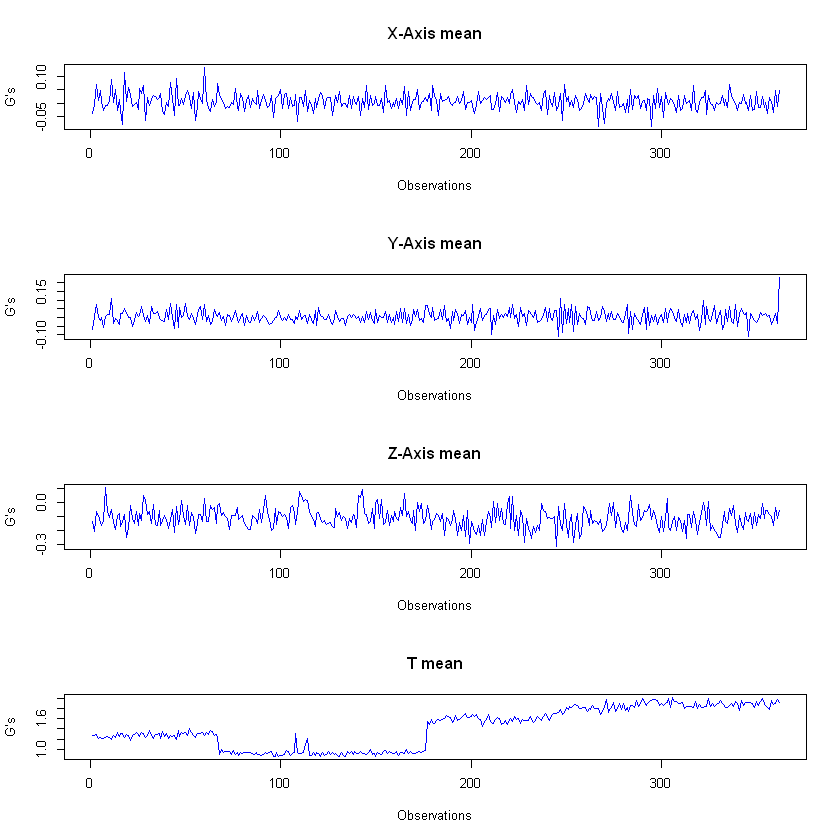

In [6]:
#plot data
par(mfrow=c(4,1))
plot(features$ax_mean, main="X-Axis mean", xlab="Observations", ylab="G's", type="l", col="blue")
plot(features$ay_mean, main="Y-Axis mean", xlab="Observations", ylab="G's", type="l", col="blue")
plot(features$az_mean, main="Z-Axis mean", xlab="Observations", ylab="G's", type="l", col="blue")
plot(features$aT_mean, main="T mean", xlab="Observations", ylab="G's", type="l", col="blue")

## Fault Detection using PCA-T2 and SPE
Principal component analysis (PCA) is a mathematical algorithm that reduces the dimensionality of the data while retaining most of the variation (information) in the data set. T2 Statistic is a multivariate statistical analysis. SPE also referred to a Q-statistic is the square prediction error. 

In [7]:
pca = function(train,test,variance, alpha,gamma) {

  #remove columns with zero variance
  train = train[sapply(train, function(x) length(levels(factor(x)))>1)]

  # calculate the pre-process parameters from the dataset
  preprocessParams = preProcess(train,
                                method=c("center", "scale"))
  # transform the dataset using the parameters
  traintransformed = predict(preprocessParams, train)
  testtransformed = predict(preprocessParams, test[,colnames(train)])

  #calibrate data for
  pca.model = mdatools::pca(x = traintransformed,
                            x.test = testtransformed,
                            alpha = alpha,
                            gamma = gamma,
                            ncomp = ncol(train))

  for(i in 1:ncol(train)){
    if(pca.model$calres$cumexpvar[i] >= variance) { break }
  }

  trainRes = data.frame(train,
                        T2stats = pca.model$calres$T2[,i],
                        T2critical = pca.model$calres$T2lim[1,i],
                        T2outlier = pca.model$calres$T2lim[2,i],
                        SPEstats = pca.model$calres$Q[,i],
                        SPEcritical = pca.model$calres$Qlim[1,i],
                        SPEoutlier = pca.model$calres$Qlim[2,i]
  )
  testRes = data.frame(test[,colnames(train)],
                       T2stats = pca.model$testres$T2[,i],
                       T2critical = pca.model$testres$T2lim[1,i],
                       T2outlier = pca.model$testres$T2lim[2,i],
                       SPEstats = pca.model$testres$Q[,i],
                       SPEcritical = pca.model$testres$Qlim[1,i],
                       SPEoutlier = pca.model$testres$Qlim[2,i]
  )

  return(rbind(trainRes,testRes))

}

The above function is the generalized function for using PCA analysis for performing anomaly detection. The input variables are the train data, test data, alpha value, gamma value and variance among principal components. 

In [8]:
train = features[1:67,2:ncol(features)]
test = features[68:nrow(features),2:ncol(features)]
alpha = 0.05
gamma = 0.01
variance = 0.95

#call pca function
pca_result = pca(train,test,variance, alpha,gamma)

The below are the graphial results for PCA analysis. From the PCA-T2 results, we can observe that the annomaly model was capable of detecting the annomalies. Likewise PCA-SPE model was capable of detecting the anomalies as well. 

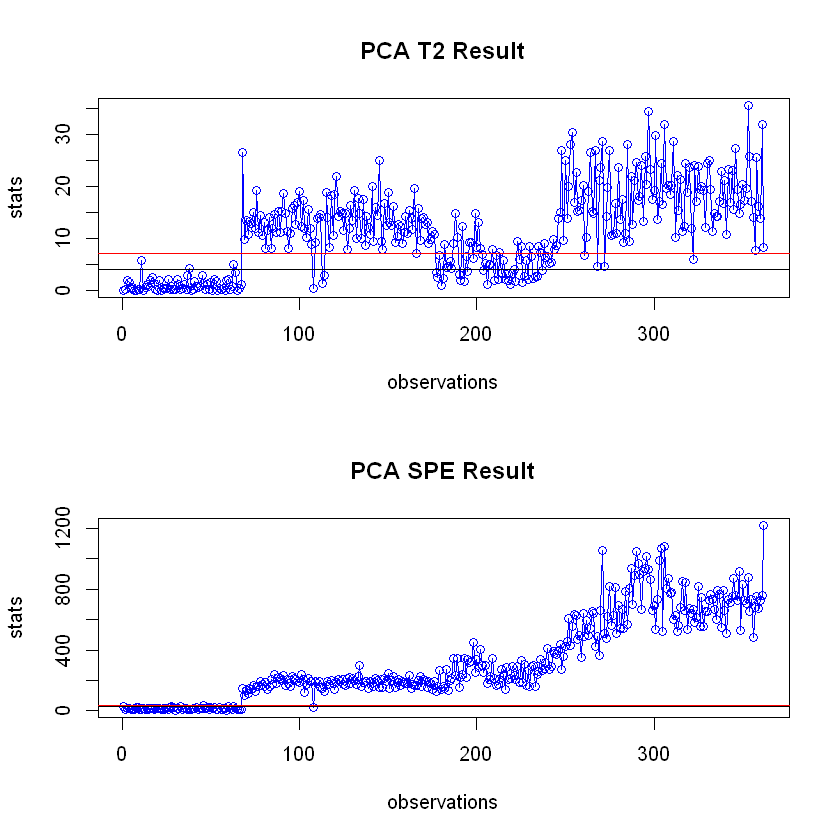

In [9]:
#plot results
par(mfrow=c(2,1))
plot(pca_result$T2stats, main="PCA T2 Result", ylab="stats", xlab="observations", col="blue", type="o")
abline(h=pca_result$T2critical, col="black")
abline(h=pca_result$T2outlier, col="red")

plot(pca_result$SPEstats, main="PCA SPE Result", ylab="stats", xlab="observations", col="blue", type="o")
abline(h=pca_result$SPEcritical, col="black")
abline(h=pca_result$SPEoutlier, col="red")

## Fault detection using K-means
K-means is one of the most common unsupervised learning clustering algorithms. This most straightforward algorithm’s goal is to divide the data set into pre-determined clusters based on distance. Here, we have used Euclidian distance.

In [10]:
kmeans = function(train, usePCA, variance) {
  #remove columns with zero variance
  train = train[sapply(train, function(x) length(levels(factor(x)))>1)]

  if(usePCA == TRUE){
    # calculate the pre-process parameters from the dataset
    preprocessParams = preProcess(train,
                                  method=c("center", "scale", "pca"),
                                  thresh = variance,
                                  na.remove = T,
                                  freqCut = 95/5,
                                  uniqueCut = 10
    )
    # transform the dataset using the parameters
    transformed = predict(preprocessParams, train)

    kmRes = stats::kmeans(as.matrix(transformed),2)

    return(data.frame(train,cluster=kmRes$cluster))
  }

  if(usePCA == FALSE){
    # calculate the pre-process parameters from the dataset
    preprocessParams = preProcess(train,
                                  method=c("center", "scale"),
                                  na.remove = T
    )
    # transform the dataset using the parameters
    transformed = predict(preprocessParams, train)

    kmRes = stats::kmeans(transformed,2)

    return(data.frame(train,cluster=kmRes$cluster))
  }
}

In [11]:
#Anomaly detection without PCA
train = features[,2:ncol(features)]
usePCA = FALSE
Variance = 0.95
kmeans_res = kmeans(train, usePCA, variance)

#Anomaly detection with PCA
usePCA = TRUE
kmeans_pca_res = kmeans(train, usePCA, variance)

Using the genralized function developed above, kmeans is used in two ways with and without PCA. In both the cases from the graphical results, we can observe that kmeans was capable of detecting the anomalies. Also, it is interesting to not that, kmeans grouped data in file 1 and file 2 and one state and file 3 and file 4 as other state. 

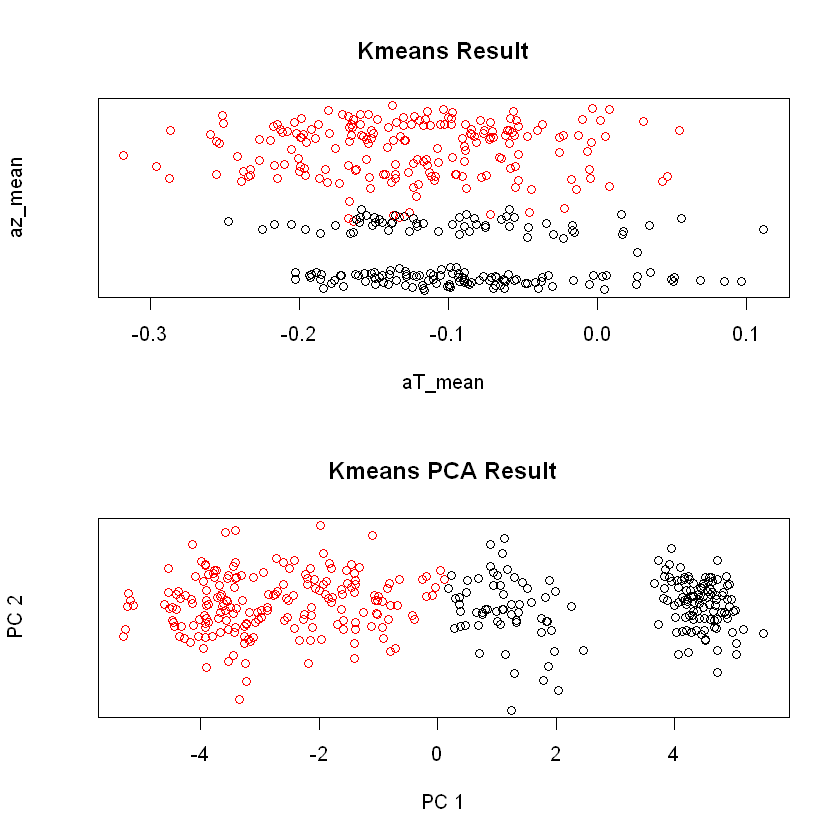

In [12]:
#plot results
par(mfrow=c(2,1))
pca.model = prcomp(train, scale=T)

plot(features$az_mean, features$aT_mean , main="Kmeans Result", ylab="az_mean", xlab="aT_mean", col=kmeans_res$cluster ,yaxt = 'n')

plot(pca.model$x, main="Kmeans PCA Result", ylab="PC 2", xlab="PC 1", col=kmeans_pca_res$cluster, yaxt = 'n')


# Fault Detection using Model Based clustering
A Gaussian mixture model (GMM) is used for modeling data that comes from one of the several groups: the groups might be different from each other, but data points within the same group can be well-modeled by a Gaussian distribution . Gaussian finite mixture model fitted by EM algorithm is an iterative algorithm where some initial random estimate starts and updates every iterate until convergence is detected . Initialization can be started based on a set of initial parameters and start E-step or set of initial weights and proceed to M-step. This step can be either set randomly or could be chosen based on some method.

In [13]:
gmm = function(train, usePCA, variance, n) {
  #remove columns with zero variance
  train = train[sapply(train, function(x) length(levels(factor(x)))>1)]
  M = nrow(train)/4
  if(usePCA == TRUE){
    # calculate the pre-process parameters from the dataset
    preprocessParams = preProcess(train,
                                  method=c("center", "scale", "pca"),
                                  thresh = variance,
                                  na.remove = T,
                                  freqCut = 95/5,
                                  uniqueCut = 10
    )
    # transform the dataset using the parameters
    traintransformed = predict(preprocessParams, train)

    m = densityMclust(traintransformed,
                      G = n,
                      initialization = list(subset = sample(1:nrow(traintransformed),
                                                            size = M),
                                            set.seed(11)))

    traintransformed$y = m$classification
    return(data.frame(traintransformed, m$z))
  }

  if(usePCA == FALSE){
    # calculate the pre-process parameters from the dataset
    preprocessParams = preProcess(train,
                                  method=c("center", "scale"),
                                  na.remove = T
    )
    # transform the dataset using the parameters
    traintransformed = predict(preprocessParams, train)

    m = densityMclust(traintransformed,
                      G = n,
                      initialization = list(subset = sample(1:nrow(traintransformed),
                                                            size = M),
                                            set.seed(11)))

    traintransformed$y = m$classification
    return(data.frame(traintransformed, m$z))
  }
}

In [14]:
#Anomaly detection without PCA
train = features[,2:ncol(features)]
usePCA = FALSE
variance = 0.95
n = 2
gmm_res = gmm(train, usePCA, variance, n)

#Anomaly detection with PCA
usePCA = TRUE
gmm_pca_res = gmm(train, usePCA, variance, n)

Using the genralized function developed above, GMM is used in two ways with and without PCA. In both the cases from the graphical results, we can observe that GMM was capable of detecting the anomalies. Also, it is interesting to not that, GMM grouped data in file 1 and file 2 and one state and file 3 and file 4 as other state.

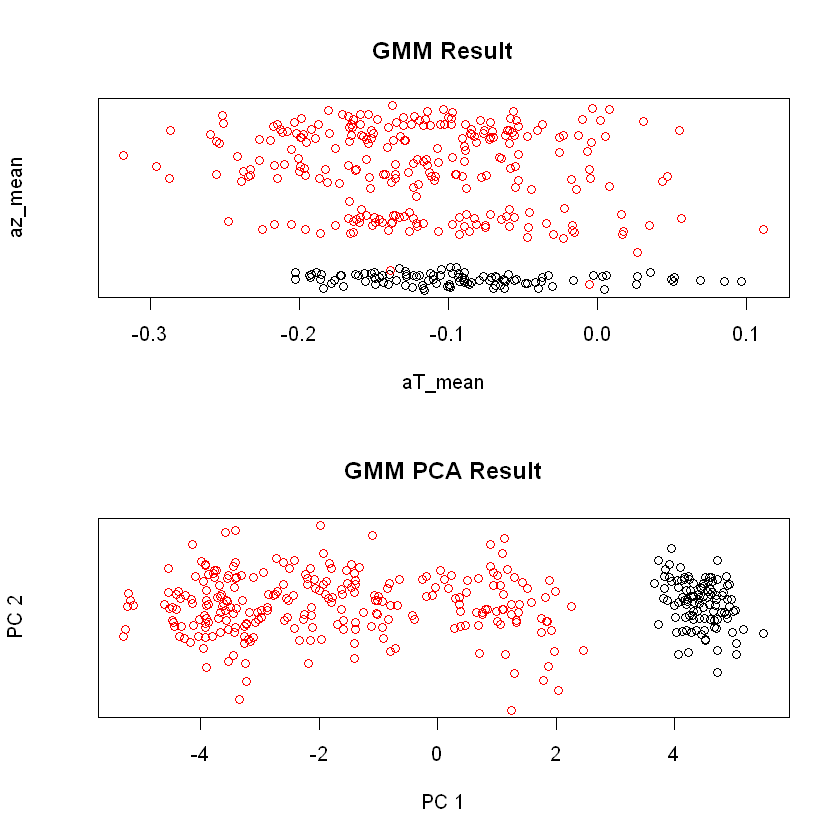

In [15]:
#plot results
par(mfrow=c(2,1))
pca.model = prcomp(train, scale=T)

plot(features$az_mean, features$aT_mean , main="GMM Result", ylab="az_mean", xlab="aT_mean", col=gmm_res$y ,yaxt = 'n')

plot(pca.model$x, main="GMM PCA Result", ylab="PC 2", xlab="PC 1", col=gmm_pca_res$y, yaxt = 'n')


#### References

[1] Amruthnath, Nagdev, and Tarun Gupta. "A research study on unsupervised machine learning algorithms for early fault detection in predictive maintenance." In 2018 5th International Conference on Industrial Engineering and Applications (ICIEA), pp. 355-361. IEEE, 2018.

[2] Amruthnath, Nagdev, and Tarun Gupta. "Fault class prediction in unsupervised learning using model-based clustering approach." In Information and Computer Technologies (ICICT), 2018 International Conference on, pp. 5-12. IEEE, 2018.